In [1]:
from tensorflow import keras
keras.__version__

'2.4.0'

## Feature extraction


![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)


Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from 
our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras. You can import it from the `keras.applications` module. Here's the list of 
image classification models (all pre-trained on the ImageNet dataset) that are available as part of `keras.applications`:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let's instantiate the VGG16 model:

In [4]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected 
classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, 
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already 
familiar with.

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [7]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'D:/college-lessons/MA/FIU/AI-workshop/dataset/catDog/data/catVsdog'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must 
flatten them to `(samples, 8192)`:

In [8]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and 
labels that we just recorded:

In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 9ms/step - loss: 0.7011 - acc: 0.5689 - val_loss: 0.4624 - val_acc: 0.8140
Epoch 2/30
100/100 [==============================] - 1s 7ms/step - loss: 0.4637 - acc: 0.7766 - val_loss: 0.3777 - val_acc: 0.8530
Epoch 3/30
100/100 [==============================] - 1s 7ms/step - loss: 0.3704 - acc: 0.8481 - val_loss: 0.3418 - val_acc: 0.8530
Epoch 4/30
100/100 [==============================] - 1s 7ms/step - loss: 0.3305 - acc: 0.8713 - val_loss: 0.3075 - val_acc: 0.8830
Epoch 5/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2915 - acc: 0.8805 - val_loss: 0.2903 - val_acc: 0.8850
Epoch 6/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2785 - acc: 0.8811 - val_loss: 0.2772 - val_acc: 0.8870
Epoch 7/30
100/100 [==============================] - 1s 7ms/step - loss: 0.2459 - acc: 0.9081 - val_loss: 0.2690 - val_acc: 0.8880
Epoch 8/30
100/100 [==============================] - 1s 7ms/step - loss: 0.

Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

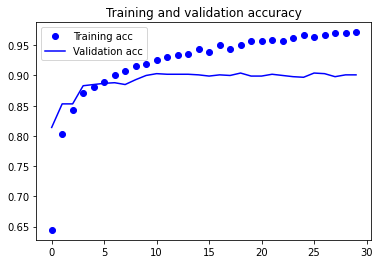

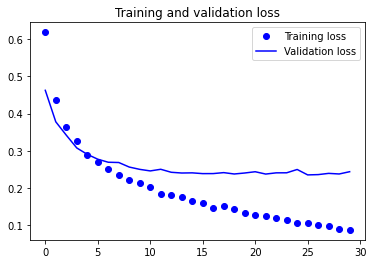

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


In [12]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [14]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [15]:
conv_base.trainable = False

In [16]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


C:\Users\msi-pc\.conda\envs\tf24\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 - 19s - loss: 0.5866 - acc: 0.6845 - val_loss: 0.4476 - val_acc: 0.8260
Epoch 2/30
100/100 - 18s - loss: 0.4823 - acc: 0.7760 - val_loss: 0.3717 - val_acc: 0.8630
Epoch 3/30
100/100 - 16s - loss: 0.4379 - acc: 0.8075 - val_loss: 0.3416 - val_acc: 0.8670
Epoch 4/30
100/100 - 16s - loss: 0.4019 - acc: 0.8230 - val_loss: 0.3116 - val_acc: 0.8690
Epoch 5/30
100/100 - 17s - loss: 0.3833 - acc: 0.8305 - val_loss: 0.2941 - val_acc: 0.8810
Epoch 6/30
100/100 - 16s - loss: 0.3726 - acc: 0.8355 - val_loss: 0.2830 - val_acc: 0.8820
Epoch 7/30
100/100 - 17s - loss: 0.3629 - acc: 0.8395 - val_loss: 0.2888 - val_acc: 0.8840
Epoch 8/30
100/100 - 17s - loss: 0.3405 - acc: 0.8565 - val_loss: 0.2737 - val_acc: 0.8790
Epoch 9/30
100/100 - 18s - loss: 0.3501 - acc: 0.8450 - val_loss: 0.2708 - val_acc: 0.8770
Epoch 10/30
100/100 - 19s - loss: 0.3232 - acc: 0.8600 - val_loss: 0.2628 - val_acc: 0.8870
Epoch 11/30
100/100 - 18s - loss: 0.3166 - acc: 0.8570 - val_loss: 0.2668 - val_acc: 0.89

In [19]:
model.save('cats_and_dogs_small_3.h5')

Let's plot our results again:

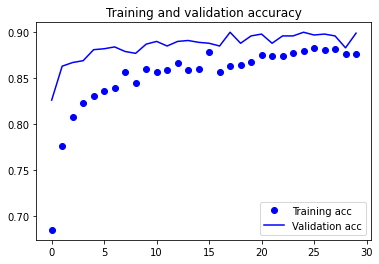

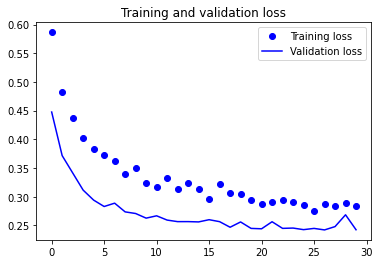

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.

## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 
Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In [21]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [22]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 20s 185ms/step - loss: 0.3050 - acc: 0.8685 - val_loss: 0.2755 - val_acc: 0.8840
Epoch 2/100
100/100 [==============================] - 19s 185ms/step - loss: 0.2694 - acc: 0.8732 - val_loss: 0.2202 - val_acc: 0.9160
Epoch 3/100
100/100 [==============================] - 19s 187ms/step - loss: 0.2326 - acc: 0.9086 - val_loss: 0.2435 - val_acc: 0.8990
Epoch 4/100
100/100 [==============================] - 18s 181ms/step - loss: 0.2821 - acc: 0.8770 - val_loss: 0.2001 - val_acc: 0.9180
Epoch 5/100
100/100 [==============================] - 19s 184ms/step - loss: 0.1981 - acc: 0.9109 - val_loss: 0.2069 - val_acc: 0.9190
Epoch 6/100
100/100 [==============================] - 19s 188ms/step - loss: 0.1887 - acc: 0.9175 - val_loss: 0.2333 - val_acc: 0.9130
Epoch 7/100
100/100 [==============================] - 19s 189ms/step - loss: 0.1864 - acc: 0.9200 - val_loss: 0.1911 - val_acc: 0.9230
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 30s 304ms/step - loss: 0.0289 - acc: 0.9892 - val_loss: 0.3316 - val_acc: 0.9190
Epoch 62/100
100/100 [==============================] - 30s 298ms/step - loss: 0.0252 - acc: 0.9908 - val_loss: 0.2023 - val_acc: 0.9370
Epoch 63/100
100/100 [==============================] - 31s 305ms/step - loss: 0.0412 - acc: 0.9876 - val_loss: 0.2441 - val_acc: 0.9330
Epoch 64/100
100/100 [==============================] - 31s 309ms/step - loss: 0.0328 - acc: 0.9896 - val_loss: 0.2184 - val_acc: 0.9370
Epoch 65/100
100/100 [==============================] - 30s 301ms/step - loss: 0.0290 - acc: 0.9893 - val_loss: 0.2233 - val_acc: 0.9320
Epoch 66/100
100/100 [==============================] - 30s 301ms/step - loss: 0.0212 - acc: 0.9921 - val_loss: 0.3081 - val_acc: 0.9250
Epoch 67/100
100/100 [==============================] - 34s 337ms/step - loss: 0.0276 - acc: 0.9892 - val_loss: 0.3751 - val_acc: 0.9230
Epoch 68/100
100/100 [===================

In [24]:
model.save('cat_and_dogs_small_4.h5')

Let's plot our results using the same plotting code as before:

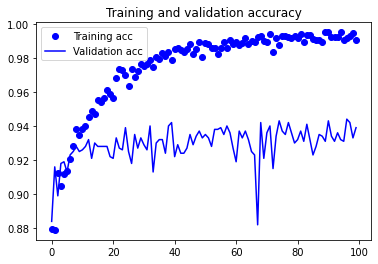

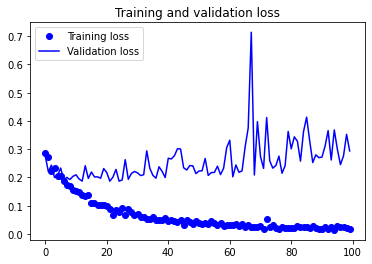

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()



These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving 
averages of these quantities. Here's a trivial utility function to do this:

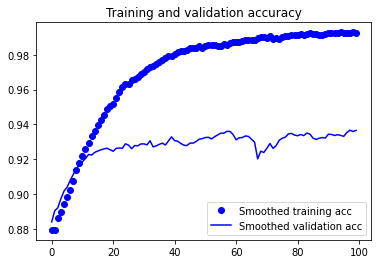

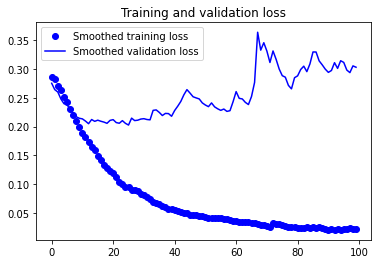

In [27]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()


In [28]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


C:\Users\msi-pc\.conda\envs\tf24\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc: 0.9369999766349792


## Contact me

### LinkedIn Account
https://www.linkedin.com/in/mohammed-behjoo-446098b7/


### YouTube Channel
https://www.youtube.com/channel/UCudI0gvPh-YbiY2zLM7im-w


### GitHub
https://github.com/mohammedbehjoo